In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.optimizers import Adam

## Data Understanding

### Load Dataset

In [2]:
# Import the data
# goal: predict scalar_coupling_const by its structure
# We will use train set and structures
train_df = pd.read_csv('Data/train.csv')
structures_df = pd.read_csv('Data/structures.csv')

In [3]:
# Observe traindf
print(train_df.shape)
print('')
print(train_df.nunique())
print('')
print(train_df.columns)
train_df.head()

(4659076, 6)

id                          4659076
molecule_name                 85012
atom_index_0                     28
atom_index_1                     29
type                              8
scalar_coupling_constant    2183446
dtype: int64

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant'],
      dtype='object')


,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [4]:
# Observe structures_df
print(structures_df.shape)
print('')
print(structures_df.nunique())
print('')
print(structures_df.columns)
structures_df.head()

(2358875, 6)

molecule_name     130789
atom_index            29
atom                   5
x                2358802
y                2358808
z                2358792
dtype: int64

Index(['molecule_name', 'atom_index', 'atom', 'x', 'y', 'z'], dtype='object')


,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


### Exploratory Data Analysis (EDA)

#### Scalar Coupling Constant (Target)

Text(0, 0.5, 'Counts')

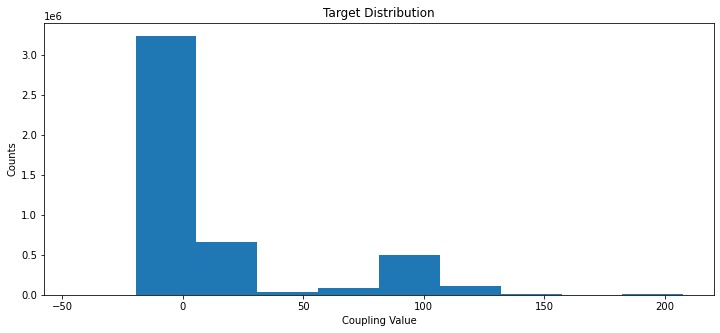

In [5]:
# Check the Distribution of Target Variable
fig, ax = plt.subplots(figsize=(12,5))

ax.hist(train_df['scalar_coupling_constant'])
ax.set_title('Target Distribution')
ax.set_xlabel('Coupling Value')
ax.set_ylabel('Counts')

#### Types of Bond

Text(0, 0.5, 'Counts')

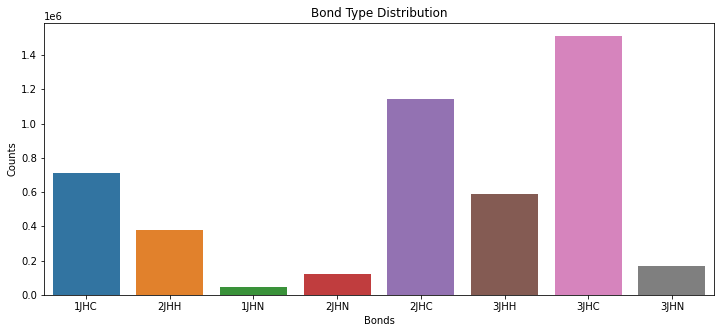

In [6]:
# Check the type of bonds
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='type', data=train_df)
ax.set_title('Bond Type Distribution')
ax.set_xlabel('Bonds')
ax.set_ylabel('Counts')

Multiple bond type might cause the trouble later on the modeling. Therefore we will create a subset based on each model type in later part.

#### Atom Index

Text(0, 0.5, 'Counts')

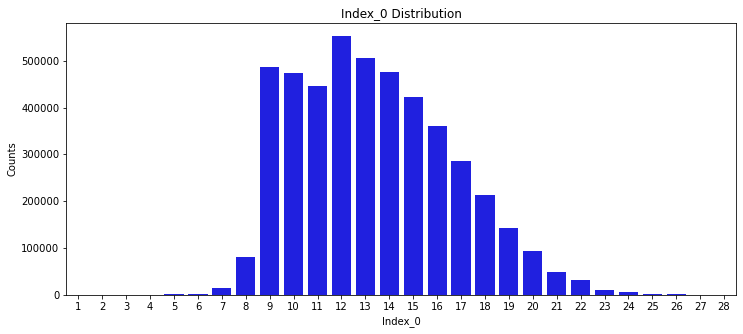

In [7]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='atom_index_0', data=train_df, color = 'blue')
ax.set_title('Index_0 Distribution')
ax.set_xlabel('Index_0')
ax.set_ylabel('Counts')

Text(0, 0.5, 'Counts')

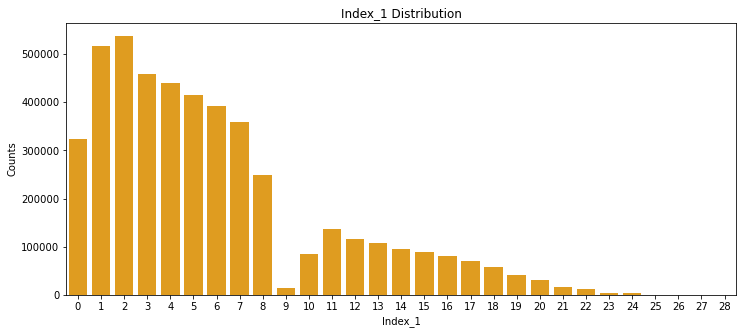

In [8]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x='atom_index_1', data=train_df, color = 'orange')
ax.set_title('Index_1 Distribution')
ax.set_xlabel('Index_1')
ax.set_ylabel('Counts')

### Feature Engineering

#### Merge Train and Structure

This merging technique has been sourced from: https://www.kaggle.com/inversion/atomic-distance-benchmark

In [9]:
def map_atom_info(df, atom_idx):
    '''
    
    '''
    df = pd.merge(df, structures_df, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [10]:
# Merge train and structures
train_df2 = map_atom_info(train_df, 0)
train_df2 = map_atom_info(train_df2, 1)
train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001


In [11]:
# check nan after merging
train_df2.isna().sum()

id                          0
molecule_name               0
atom_index_0                0
atom_index_1                0
type                        0
scalar_coupling_constant    0
atom_0                      0
x_0                         0
y_0                         0
z_0                         0
atom_1                      0
x_1                         0
y_1                         0
z_1                         0
dtype: int64

#### Distance between Atoms

In [12]:
# Calculate the 3D distance between atom
train_df2['distance'] = ((train_df2['x_0']-train_df2['x_1'])**2 +
(train_df2['y_0']-train_df2['y_1'])**2 + (train_df2['z_0']-train_df2['z_1'])**2)**0.5

train_df2.head()

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance
0,0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,C,-0.012698,1.085804,0.008001,1.091953
1,1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,1.011731,1.463751,0.000277,1.783120
2,2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,-0.540815,1.447527,-0.876644,1.783147
3,3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,-0.523814,1.437933,0.906397,1.783157
4,4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,C,-0.012698,1.085804,0.008001,1.091952


Before we enter train test split, we will make a subset of train_df2 based on the bond type.

According to the bar plot in 'Type of Bond' section, we know that there are 8 types of bond:

- {'1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'}

In [13]:
train_df2['type'].value_counts()

3JHC    1511207
2JHC    1140867
1JHC     709133
3JHH     590529
2JHH     377988
3JHN     166613
2JHN     119059
1JHN      43680
Name: type, dtype: int64

In [14]:
def subset(btype):
    '''
    This function creates and returns subset of the train_df2. 
    It will locate the rows with certain bond type and generate subset.
    
    input: btype
    Options for btype: {'1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'}
    
    output: subset in form of dataframe
    '''
    df = train_df2.loc[train_df2['type'] == btype]
    
    return df

In [15]:
c1_df = subset('1JHC')
n1_df = subset('1JHN')
c2_df = subset('2JHC')
h2_df = subset('2JHH')
n2_df = subset('2JHN')
c3_df = subset('3JHC')
h3_df = subset('3JHH')
n3_df = subset('3JHN')

In [16]:
# check if the subset are well splitted
print('c1')
print(c1_df['type'].value_counts())
print('')
print('c2')
print(c2_df['type'].value_counts())
print('')
print('c3')
print(c3_df['type'].value_counts())
print('')
print('n1')
print(n1_df['type'].value_counts())
print('')
print('n2')
print(n2_df['type'].value_counts())
print('')
print('n3')
print(n3_df['type'].value_counts())
print('')
print('h2')
print(h2_df['type'].value_counts())
print('')
print('h3')
print(h3_df['type'].value_counts())

c1
1JHC    709133
Name: type, dtype: int64

c2
2JHC    1140867
Name: type, dtype: int64

c3
3JHC    1511207
Name: type, dtype: int64

n1
1JHN    43680
Name: type, dtype: int64

n2
2JHN    119059
Name: type, dtype: int64

n3
3JHN    166613
Name: type, dtype: int64

h2
2JHH    377988
Name: type, dtype: int64

h3
3JHH    590529
Name: type, dtype: int64


#### Train Test Split

We will split the train_df2 into X and y. We will exclude columns id and molecule_name 
- X: All columns else than trarget variable(scalar_coupling_constant), id, molecule_name, and type
    - We will exclude columns id and molecule_name since those two does not contribute to the scalar coupling constant.
    - type will be dropped since all the df are now the subset with same bond type
- y: target variable (scalar_coupling_constant)

We will also create function for whole process since we have to run for each subset.

Moreover, we will conduct train test split twice to create train set, validation set, and test set.The ratio for this split will be 80% for train, 10% for validation and test, which is a common ratio.

In [17]:
def ttv_split(df):
    '''
    This function splits the set of dataframe into train, validation, and test set with ration of 80:10:10.
    '''
    X = df.drop(columns = ['id', 'molecule_name', 'scalar_coupling_constant','type'])
    y = df[['scalar_coupling_constant']]
    
    # Split into train and test
    # ratio train 90% : test 10%
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .10, random_state = 1)
    
    # Split into train and val
    # ratio train 80% : val 10% : test 10%
    # to achieve this test_size should be 1/9
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 1/9, random_state =1)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

In [18]:
c1_X_train, c1_X_test, c1_X_val, c1_y_train, c1_y_test, c1_y_val = ttv_split(c1_df)
c2_X_train, c2_X_test, c2_X_val, c2_y_train, c2_y_test, c2_y_val = ttv_split(c2_df)
c3_X_train, c3_X_test, c3_X_val, c3_y_train, c3_y_test, c3_y_val = ttv_split(c3_df)
n1_X_train, n1_X_test, n1_X_val, n1_y_train, n1_y_test, n1_y_val = ttv_split(n1_df)
n2_X_train, n2_X_test, n2_X_val, n2_y_train, n2_y_test, n2_y_val = ttv_split(n2_df)
n3_X_train, n3_X_test, n3_X_val, n3_y_train, n3_y_test, n3_y_val = ttv_split(n3_df)
h2_X_train, h2_X_test, h2_X_val, h2_y_train, h2_y_test, h2_y_val = ttv_split(h2_df)
h3_X_train, h3_X_test, h3_X_val, h3_y_train, h3_y_test, h3_y_val = ttv_split(h3_df)

In [19]:
c1_X_train.head()

,atom_index_0,atom_index_1,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance
1794965,9,0,H,0.255344,2.312081,0.654561,C,-0.695524,1.794885,0.500323,1.093358
3194028,9,0,H,0.919415,2.042258,-0.006993,C,-0.065870,1.565067,-0.063755,1.096229
4002445,11,0,H,-0.096303,1.323997,1.330618,C,0.144958,1.163510,0.278043,1.091731
1571087,15,7,H,3.359409,3.561537,-2.932070,C,3.117779,3.009572,-2.027701,1.086707
4323126,11,0,H,-0.876799,1.893361,0.697739,C,-0.120853,1.547940,-0.014709,1.094693


In [20]:
c1_X_val.head()

,atom_index_0,atom_index_1,atom_0,x_0,y_0,z_0,atom_1,x_1,y_1,z_1,distance
3488947,14,2,H,1.663497,0.079107,1.509084,C,0.718083,-0.440318,1.328619,1.093699
1368134,13,6,H,3.088595,2.403053,1.298326,C,2.562035,2.704758,0.389108,1.093146
2496347,9,0,H,0.516420,2.155714,0.118905,C,-0.332618,1.491548,-0.064319,1.093413
2883908,11,0,H,-0.556952,1.868895,0.938078,C,-0.024147,1.465134,0.055208,1.107413
389129,11,2,H,-2.009111,0.068135,0.407309,C,-1.317965,-0.502299,-0.226471,1.097613


Great! Train test split was successful.

#### Preprocessing Pipeline

First, we will divide up the columns into numerical and categorical.

In [21]:
# Create a train_df3
# exclude scalar_coupling_constant, id, molecule_name, and type
train_df3 = train_df2.drop(columns=['scalar_coupling_constant', 'id', 'molecule_name', 'type'])

In [22]:
train_df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4659076 entries, 0 to 4659075
Data columns (total 11 columns):
 #   Column        Dtype  
---  ------        -----  
 0   atom_index_0  int64  
 1   atom_index_1  int64  
 2   atom_0        object 
 3   x_0           float64
 4   y_0           float64
 5   z_0           float64
 6   atom_1        object 
 7   x_1           float64
 8   y_1           float64
 9   z_1           float64
 10  distance      float64
dtypes: float64(7), int64(2), object(2)
memory usage: 426.6+ MB


In [23]:
# initialize lists of columns
num_cols = []
cat_cols = []

# num = any columns with numerical value
# cat = everything else
for c in train_df3.columns:
    if train_df3[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    else:
        cat_cols.append(c)

In [24]:
num_cols

['atom_index_0',
 'atom_index_1',
 'x_0',
 'y_0',
 'z_0',
 'x_1',
 'y_1',
 'z_1',
 'distance']

In [25]:
cat_cols

['atom_0', 'atom_1']

First, define the transformers for each column type using pipeline.

In [26]:
# Define transformers using pipeline
num_transformer = Pipeline(steps=[('minmaxscaler', MinMaxScaler())])
cat_transformer = Pipeline(steps=[('encoder', OneHotEncoder())])

Then, combine transformers into preprocessor using ColumnTransformer.

In [27]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols),
    ])

Finally, we will fit the preprocessor to X_train

In [28]:
preprocessor.fit(c1_X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['atom_index_0', 'atom_index_1', 'x_0', 'y_0',
                                  'z_0', 'x_1', 'y_1', 'z_1', 'distance']),
                                ('cat',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 ['atom_0', 'atom_1'])])

## Modeling

### 1. First Simple Model

Our first simple model will be the linear regression model.

In [31]:
def fit_and_eval(regressor, X_train, y_train, X_val, y_val):
    model = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', regressor)
                        ])
    #print(cross_validate(lr, X_train, y_train, return_train_score=True))
    model.fit(X_train, y_train)
    tr_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    print('Result Report')
    print('')
    print(f'Train R2 Score: {r2_score(y_train, tr_pred)}')
    print(f'Validation R2 Score: {r2_score(y_val, val_pred)}')
    print('')
    print(f'Train RMSE: {mean_squared_error(y_train, tr_pred, squared = False)}')
    print(f'Validation RMSE: {mean_squared_error(y_val, val_pred, squared = False)}')
    print('')
    print(f'Validation MAE: {mean_absolute_error(y_train, tr_pred)}')
    print(f'Validation MAE: {mean_absolute_error(y_val, val_pred)}')
    plt.scatter(y_val,val_pred)
    plt.plot(y_val, y_val, c="Red")
    plt.xlabel('true value')
    plt.ylabel('prediction')

#### 1.1 1JHC

Result Report

Train R2 Score: 0.5463159135570067
Validation R2 Score: 0.5466896074871468

Train RMSE: 12.300764664124433
Validation RMSE: 12.41686142345409

Validation MAE: 8.604505167515708
Validation MAE: 8.655867320505603


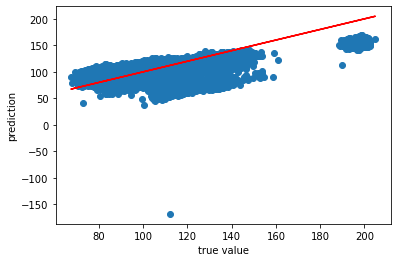

In [33]:
fit_and_eval(LinearRegression(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

#### 1.2 1JHN

Result Report

Train R2 Score: 0.7776016589642134
Validation R2 Score: 0.7692073085341721

Train RMSE: 5.135596428462661
Validation RMSE: 5.280458232881145

Validation MAE: 3.401400469714534
Validation MAE: 3.5418138658999734


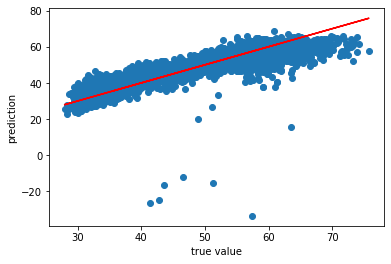

In [34]:
fit_and_eval(LinearRegression(), n1_X_train, n1_y_train, n1_X_val, n1_y_val)

#### 1.3 2JHC

Result Report

Train R2 Score: 0.09644985685706409
Validation R2 Score: 0.0952199209598461

Train RMSE: 4.301247926808028
Validation RMSE: 4.312422305375372

Validation MAE: 2.650960987982246
Validation MAE: 2.6500908475586975


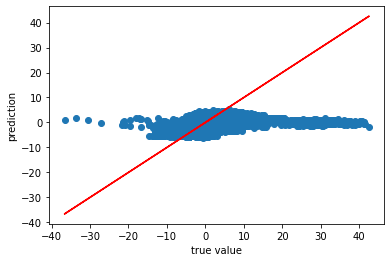

In [35]:
fit_and_eval(LinearRegression(), c2_X_train, c2_y_train, c2_X_val, c2_y_val)

#### 1.4 2JHH

Result Report

Train R2 Score: 0.3111021071210358
Validation R2 Score: 0.30861614751726074

Train RMSE: 3.29890050412273
Validation RMSE: 3.3520983155489463

Validation MAE: 1.9697426947116417
Validation MAE: 1.992494060153671


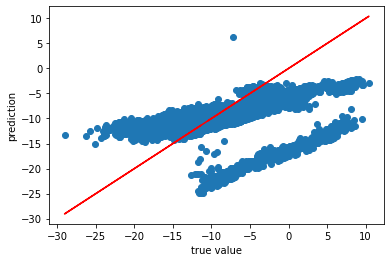

In [36]:
fit_and_eval(LinearRegression(), h2_X_train, h2_y_train, h2_X_val, h2_y_val)

#### 1.5 2JHN

Result Report

Train R2 Score: 0.1509045946494092
Validation R2 Score: 0.16738611099251088

Train RMSE: 3.389858901178878
Validation RMSE: 3.3468528524803514

Validation MAE: 2.677249029675603
Validation MAE: 2.6416079105230805


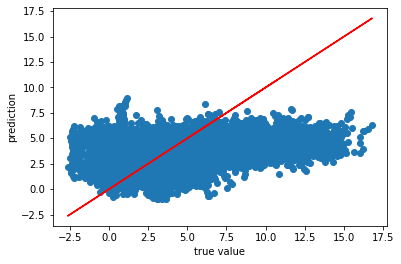

In [37]:
fit_and_eval(LinearRegression(), n2_X_train, n2_y_train, n2_X_val, n2_y_val)

#### 1.6 3JHC

Result Report

Train R2 Score: 0.10672838645656568
Validation R2 Score: 0.10483876692355376

Train RMSE: 2.906292433618292
Validation RMSE: 2.9121584059046497

Validation MAE: 2.2814566542555634
Validation MAE: 2.284753958981355


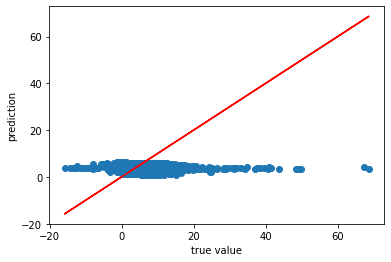

In [38]:
fit_and_eval(LinearRegression(), c3_X_train, c3_y_train, c3_X_val, c3_y_val)

#### 1.7 3JHH

Result Report

Train R2 Score: 0.08150933669394467
Validation R2 Score: 0.0820803660764653

Train RMSE: 3.5521686872451075
Validation RMSE: 3.5435678383515388

Validation MAE: 2.9695985976538983
Validation MAE: 2.961684597278121


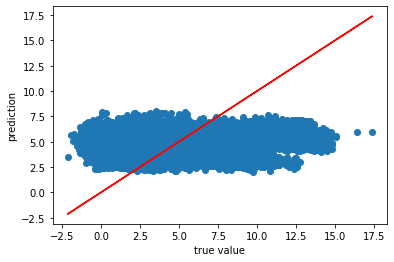

In [39]:
fit_and_eval(LinearRegression(), h3_X_train, h3_y_train, h3_X_val, h3_y_val)

#### 1.8 3JHN

Result Report

Train R2 Score: 0.08630688219038385
Validation R2 Score: 0.08851715689720507

Train RMSE: 1.2612047121224848
Validation RMSE: 1.2675154400713355

Validation MAE: 0.9272627346211364
Validation MAE: 0.9276441967998348


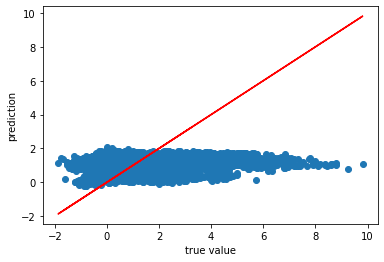

In [40]:
fit_and_eval(LinearRegression(), n3_X_train, n3_y_train, n3_X_val, n3_y_val)

Our linear regression models results proves that the most of the bond type cannot be explained with simple linear regression. Only two reasonable R_squared value is that of 1JHC and 1JHN. However, they are both below 0.8 which proves that we need to try out different regression models.

### 2. Random Forest Regressor

#### 2.1 1JHC

In [ ]:
fit_and_eval(RandomForestRegressor(), c1_X_train, c1_y_train, c1_X_val, c1_y_val)

C:\Users\Paul\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py:335: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


### 3. Neural Networks

In [ ]:
X_train.shape

In [ ]:
def create_model(optimizer='adam',
                 kernel_initializer='glorot_uniform', 
                 dropout=0.2):
    model = Sequential()
    model.add(Dense(64,activation='relu',kernel_initializer=kernel_initializer,input_shape = (14,)))
    model.add(Dropout(dropout))
    model.add(Dense(1,activation='linear',kernel_initializer=kernel_initializer))

    model.compile(loss='mean_absolute_error',optimizer=optimizer)

    return model

In [ ]:
nn1.fit(X_train, y_train, validation_data=(X_val,y_val.values),epochs=10, batch_size=10)